## **Project Name: movie-review-ml-model**

**Intern Name: Suraj Sanap**

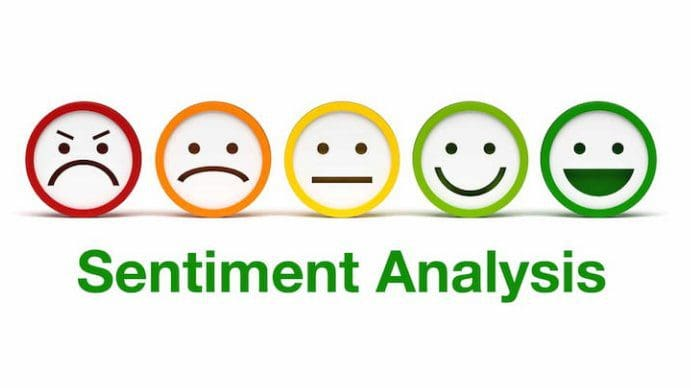

In [ ]:
import numpy as np
import pandas as pd

****Read file****

In [ ]:
df = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", delimiter="\t")

In [ ]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
EDA

<Axes: xlabel='sentiment', ylabel='count'>

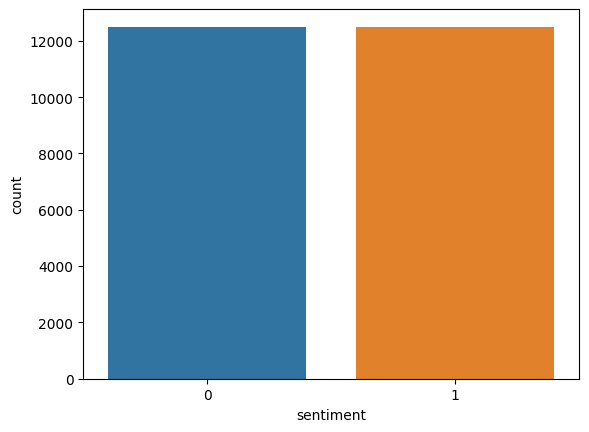

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x = df["sentiment"], data= df)

<Axes: xlabel='count', ylabel='sentiment'>

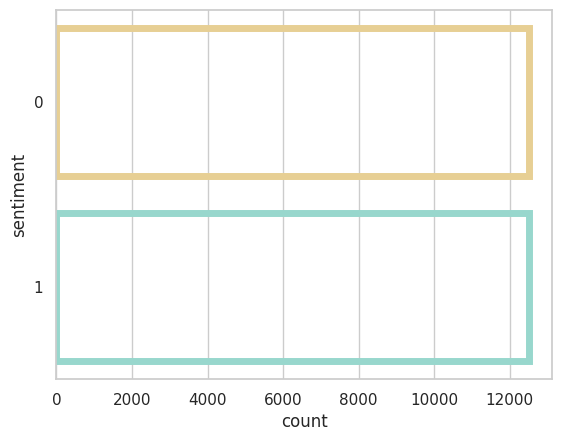

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(data=df, y="sentiment",color="salmon", facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("BrBG", 2))

**Data PreProcessing**

In [ ]:
df.shape

(25000, 3)

In [ ]:
df.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

In [ ]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
def preprocessing(text):
    clean_text = re.sub(r'<.*?>', "", text)
    clean_text = re.sub(r'https?://\S+|www\.\S+', "", clean_text)
    clean_text = re.sub(r'[\d!@#$%^&*()?><:"|;\'.]', "", clean_text)
    clean_text = re.sub(f"[{re.escape(string.punctuation)}]", "", clean_text)
    clean_text = re.sub(re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE), "", clean_text)

    #clean_text = re.sub(r'\s+', ' ', clean_text)
    clean_text = re.sub(r'\.\.\.', '',  clean_text)
    clean_text = re.sub(r'[^a-zA-Z ]', '', clean_text)

    return "".join(clean_text)

Train Test

In [ ]:
x_train = df["review"].apply(preprocessing)
y_train = df["sentiment"]

In [ ]:
x_train.head()

0    With all this stuff going down at the moment w...
1    The Classic War of the Worlds by Timothy Hines...
2    The film starts with a manager Nicholas Bell g...
3    It must be assumed that those who praised this...
4    Superbly trashy and wondrously unpretentious s...
Name: review, dtype: object

TEST data

In [ ]:
test_df = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip", delimiter="\t")
x_test = test_df["review"].apply(preprocessing)

In [ ]:
unique_words = set()
for i in x_train:
    unique_words.update(i.split())

vocab = len(unique_words)


In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
vector = TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=100,


)

vector.adapt(x_train, batch_size=32)

x_train = vector(x_train)
x_test = vector(x_test)

In [ ]:
x_train.shape

TensorShape([25000, 100])

In [ ]:
x_test.shape

TensorShape([25000, 100])

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Embedding, LSTM,Dropout
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=15, input_length=100),
    LSTM(128),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid"),
])

model.compile(loss=BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])
hist = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
782/782 [==============================] - 75s 92ms/step - loss: 0.5193 - accuracy: 0.7285
Epoch 2/5
782/782 [==============================] - 72s 92ms/step - loss: 0.3359 - accuracy: 0.8644
Epoch 3/5
782/782 [==============================] - 71s 91ms/step - loss: 0.2725 - accuracy: 0.8950
Epoch 4/5
782/782 [==============================] - 72s 92ms/step - loss: 0.2331 - accuracy: 0.9124
Epoch 5/5
782/782 [==============================] - 72s 92ms/step - loss: 0.1818 - accuracy: 0.9327


In [ ]:
pred = model.predict(x_test.numpy())
pred = np.array([0 if i < 0.5 else 1 for i in pred])

782/782 [==============================] - 27s 34ms/step


In [ ]:
submission = pd.DataFrame({'id':test_df['id'],'sentiment':pred})
submission.head()

,id,sentiment
0,12311_10,1
1,8348_2,1
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [ ]:
submission.to_csv('submission.csv',index=False)